In [67]:
import model.ieeg_cnn_rnn
import model.train

import processing.util as util
import keras

import os
import numpy as np
from sklearn.model_selection import train_test_split


from keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import scale
import h5py
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/Users/adam2392/Documents/dnn-unsupervised/.venv/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# 1. Initialize the Model (CNN and CNN+LSTM)

In [46]:
imsize=32
numfreqs = 4
ieegdnn = model.ieeg_cnn_rnn.IEEGdnn(imsize=imsize, n_colors=numfreqs)

In [48]:
w_init = None
n_layers = (4,2,1)
poolsize = (2,2)
filtersize = (3,3)

size_fc = 1024
DROPOUT = False #True

# VGG-12 style later
vggcnn = ieegdnn._build_2dcnn(w_init=w_init, n_layers=n_layers, 
                              poolsize=poolsize, filter_size=filtersize)
print(vggcnn.output)
vggcnn = ieegdnn._build_seq_output(vggcnn, size_fc, DROPOUT)
print(vggcnn.summary())

Tensor("max_pooling2d_12/MaxPool:0", shape=(?, 1, 1, 128), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 32, 32, 4)         0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 30, 30, 32)        1184      
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 28, 28, 32)        9248      
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 26, 26, 32)        9248      
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 12, 12, 32)        0         
_________________________________________________________________
co

In [17]:
# load in CNN/LSTM
num_timewins = 5
size_mem = 128
size_fc = 1024
DROPOUT = False
cnn_lstm = ieegdnn.build_cnn_lstm(num_timewins=num_timewins, 
                                  size_mem=size_mem, size_fc=size_fc, DROPOUT=DROPOUT)

print(cnn_lstm.get_shape)

/Users/adam2392/Documents/dnn-unsupervised/dnn/model/ieeg_cnn_rnn.py:189: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  model.add(Merge(convnets, mode='concat'))


<bound method Tensor.get_shape of <tf.Tensor 'dense_17/truediv:0' shape=(?, 5, 2) dtype=float32>>


# 2. Load Image Data

In [49]:
# define data filepath to images
image_filepath = os.path.join('./traindata/finaltrain/trainimages.npy')
images = np.load(image_filepath)

# load the ylabeled data
ylabel_filepath = os.path.join('./traindata/finaltrain/trainlabels.npy')
ylabels = np.load(ylabel_filepath)

print(ylabels.shape)
print(images.shape)


(66169, 1)
(66169, 4, 32, 32)


In [50]:
images = images.swapaxes(1,3)
print(images.shape)

(66169, 32, 32, 4)


In [51]:
invert_y = 1 - ylabels

ylabels = np.concatenate((ylabels, invert_y),axis=1)
print(ylabels.shape)

(66169, 2)


In [52]:
# split into train,valid,test sets
datahandler = util.DataHandler()

# format the data correctly 
# (X_train, y_train), (X_val, y_val), (X_test, y_test) = datahandler.reformatinput(images, labels)
X_train, X_test, y_train, y_test = train_test_split(images, ylabels, test_size=0.33, random_state=42)
X_train = X_train.astype("float32")
X_test = X_test.astype("float32")

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(type(X_train))
print(type(X_train[0,0,0,0]))
# print(X_val.shape)

(44333, 32, 32, 4)
(44333, 2)
(21836, 32, 32, 4)
<class 'numpy.ndarray'>
<class 'numpy.float32'>


# 3. Train CNN

In [53]:
loss = 'binary_crossentropy'
optimizer = keras.optimizers.Adam(lr=0.001, 
                                        beta_1=0.9, 
                                        beta_2=0.999,
                                        epsilon=1e-08,
                                        decay=0.0)
metrics = ['accuracy']
vggcnn.compile(loss=loss, optimizer=optimizer, metrics=metrics)
cnn_config = ieegdnn.compile_model(vggcnn, loss=loss, optimizer=optimizer, metrics=metrics)

In [21]:
display(cnn_config)

[{'class_name': 'InputLayer',
  'config': {'batch_input_shape': (None, 32, 32, 4),
   'dtype': 'float32',
   'name': 'input_6',
   'sparse': False}},
 {'class_name': 'Conv2D',
  'config': {'activation': 'relu',
   'activity_regularizer': None,
   'batch_input_shape': (None, 32, 32, 4),
   'bias_constraint': None,
   'bias_initializer': {'class_name': 'Zeros', 'config': {}},
   'bias_regularizer': None,
   'data_format': 'channels_last',
   'dilation_rate': (1, 1),
   'dtype': 'float32',
   'filters': 32,
   'kernel_constraint': None,
   'kernel_initializer': {'class_name': 'VarianceScaling',
    'config': {'distribution': 'uniform',
     'mode': 'fan_avg',
     'scale': 1.0,
     'seed': None}},
   'kernel_regularizer': None,
   'kernel_size': (3, 3),
   'name': 'conv2d_36',
   'padding': 'valid',
   'strides': (1, 1),
   'trainable': True,
   'use_bias': True}},
 {'class_name': 'Conv2D',
  'config': {'activation': 'relu',
   'activity_regularizer': None,
   'batch_input_shape': (None,

In [64]:
# images = scale(images, axis=0, with_mean=True, with_std=True, copy=True )
traindatadir = './_training/'
tempdatadir = './_training/'

# checkpoint
filepath=os.path.join(tempdatadir,"weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5")
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
def poly_decay(epoch):
    # initialize the maximum number of epochs, base learning rate,
    # and power of the polynomial
    maxEpochs = NUM_EPOCHS
    baseLR = INIT_LR
    power = 1.0
    # compute the new learning rate based on polynomial decay
    alpha = baseLR * (1 - (epoch / float(maxEpochs))) ** power
    # return the new learning rate
    return alpha

callbacks = [checkpoint, keras.callbacks.LearningRateScheduler(poly_decay)]

In [71]:
NUM_EPOCHS = 30
batch_size = 32 # or 64... or 24
# construct the image generator for data augmentation and construct
# the set of callbacks
aug = keras.preprocessing.image.ImageDataGenerator(width_shift_range=0.1,
    height_shift_range=0.1, horizontal_flip=True,
    fill_mode="nearest")
# callbacks = [keras.callbacks.LearningRateScheduler(model.train.poly_decay)]
INIT_LR = 5e-3
G=1

In [ ]:
print(vggcnn.output_shape)

HH = vggcnn.fit_generator(
    aug.flow(X_train, y_train, batch_size=batch_size * G), # adds augmentation to data using generator
    validation_data=(X_test, y_test),  
    steps_per_epoch=len(X_train) // (batch_size * G),    #
    epochs=NUM_EPOCHS,
    callbacks=callbacks, verbose=2)

(None, 2)
Epoch 1/30


{'epochs': 1, 'steps': 1385, 'verbose': 2, 'do_validation': True, 'metrics': ['loss', 'acc', 'val_loss', 'val_acc']}
dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


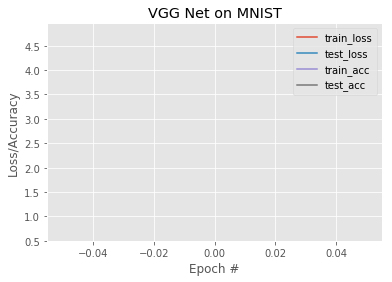

In [70]:
import matplotlib.pyplot as plt
H = HH.history
print(HH.params)
print(H.keys())

# plot the training loss and accuracy
N = np.arange(0, len(H["loss"]))
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H["loss"], label="train_loss")
plt.plot(N, H["val_loss"], label="test_loss")
plt.plot(N, H["acc"], label="train_acc")
plt.plot(N, H["val_acc"], label="test_acc")
plt.title("VGG Net on MNIST")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

# print(model.summary())

# 4. Use CNN to Train CNN-LSTM